In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import torch
import torch.nn as nn
from torch.autograd import Variable

the data we create is composed of three cosine functions superimposed


In [3]:
def normalizeAB(a, b, x):
    minX = x.min()
    maxX = x.max()
    return (b - a) * ((x - minX) / (maxX - minX)) + a

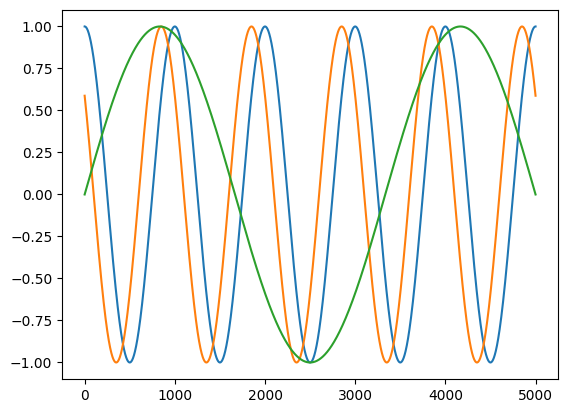

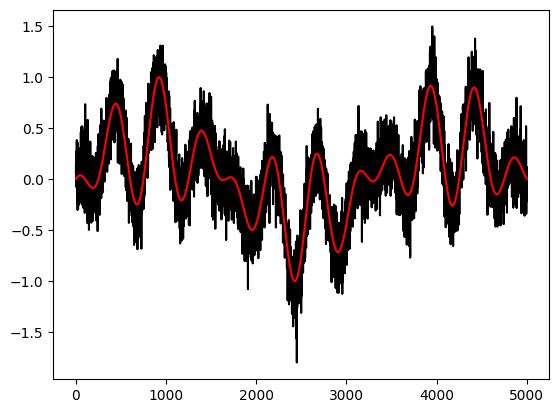

In [4]:
x = linspace(0, numpy.pi * 10, 5001)
A = numpy.cos(x)
B = numpy.cos(x + numpy.pi * 0.3)
C = numpy.cos((x + numpy.pi * 5) * 0.3)
plot(A)
plot(B)
plot(C)
figure()
rawData = normalizeAB(-1, 1, A * B * C)
noise = numpy.random.normal(0, 0.2, 5001)
data = rawData + noise
plot(data, "k")
plot(rawData, "r")

consider the first 3000 datapoints training data and the remaining 2000 test data


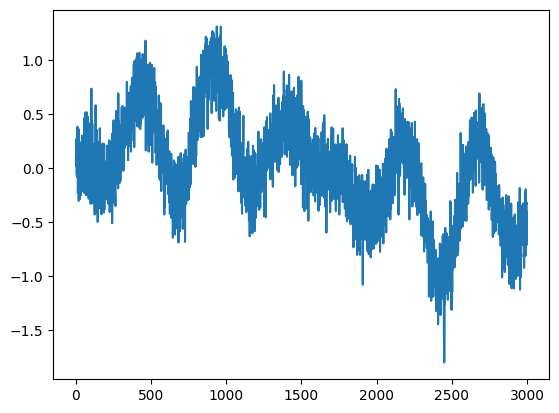

In [5]:
train_data = data[:3000]
test_data = data[3000:]

train_data, test_data
train_data_normalized = train_data
test_data_normalized = test_data
plot(train_data_normalized)

Consult code along 14 for RNN and LSTM support, implement your RNN and your LSTM


Take the "data" variable (defined above) and create four different training sets that differ in length (3,30,100,300)


In [9]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i : i + tw]
        train_label = input_data[i + tw : i + tw + 1]
        inout_seq.append((train_seq.flatten(), train_label))
    return inout_seq


train_window_3 = 3
train_window_30 = 30
train_window_100 = 100
train_window_300 = 300

train_inout_seq_3 = create_inout_sequences(train_data_normalized, train_window_3)
train_inout_seq_30 = create_inout_sequences(train_data_normalized, train_window_30)
train_inout_seq_100 = create_inout_sequences(train_data_normalized, train_window_100)
train_inout_seq_300 = create_inout_sequences(train_data_normalized, train_window_300)

test_inout_seq_3 = create_inout_sequences(test_data_normalized, train_window_3)
test_inout_seq_30 = create_inout_sequences(test_data_normalized, train_window_30)
test_inout_seq_100 = create_inout_sequences(test_data_normalized, train_window_100)
test_inout_seq_300 = create_inout_sequences(test_data_normalized, train_window_300)

In [10]:
print(train_inout_seq_3)
print(np.shape(train_inout_seq_300))

[(array([0.06559105, 0.15394623, 0.08791245]), array([0.01971722])), (array([0.15394623, 0.08791245, 0.01971722]), array([0.27193831])), (array([0.08791245, 0.01971722, 0.27193831]), array([0.19307434])), (array([0.01971722, 0.27193831, 0.19307434]), array([-0.06694069])), (array([ 0.27193831,  0.19307434, -0.06694069]), array([0.18402926])), (array([ 0.19307434, -0.06694069,  0.18402926]), array([0.05366679])), (array([-0.06694069,  0.18402926,  0.05366679]), array([-0.08107028])), (array([ 0.18402926,  0.05366679, -0.08107028]), array([0.38345498])), (array([ 0.05366679, -0.08107028,  0.38345498]), array([-0.00973294])), (array([-0.08107028,  0.38345498, -0.00973294]), array([0.01889129])), (array([ 0.38345498, -0.00973294,  0.01889129]), array([-0.23074414])), (array([-0.00973294,  0.01889129, -0.23074414]), array([-0.1612591])), (array([ 0.01889129, -0.23074414, -0.1612591 ]), array([0.28372359])), (array([-0.23074414, -0.1612591 ,  0.28372359]), array([-0.20731854])), (array([-0.1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2700, 2) + inhomogeneous part.

Now train an RNN on those four different datasets, remember we use the first 3000 datapoints as training data
after training, plot the test accuracy and training accuracy for all datapoints


In [12]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        nr_of_layers_in_rnn = 1

        self.rnn = nn.RNN(
            input_size,
            self.hidden_layer_size,
            nr_of_layers_in_rnn,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, 1, self.hidden_layer_size)
        rnn_out, h0 = self.rnn(input_seq, h0)
        # print("h0", h0.shape)
        out = self.linear(rnn_out)
        return out[0][-1]


model = RNN()
print(model)
print(train_inout_seq_3[0][0], train_inout_seq_3[0][1])
sequence = torch.Tensor(train_inout_seq_3[0][0].reshape(1, train_window_3, 1))
out = model(sequence)
print()
print(sequence.shape, out.shape)

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[0.06559105 0.15394623 0.08791245] [0.01971722]

torch.Size([1, 3, 1]) torch.Size([1])


In [ ]:
# LSTM

In [13]:
model = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

epochs = 10
losses_3 = []

for i in range(epochs):
    running_loss = 0
    for seq, labels in train_inout_seq_3:
        optimizer.zero_grad()
        # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        #                torch.zeros(1, 1, model.hidden_layer_size))

        # y_pred = model(seq)
        y_pred = model(torch.Tensor(seq.reshape(1, train_window_3, 1)))

        single_loss = loss_function(y_pred, torch.Tensor(labels))
        single_loss.backward()
        optimizer.step()
        running_loss += single_loss.item()
    avg_loss = running_loss / len(train_inout_seq_3)
    losses_3.append(avg_loss)

    if i % 25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")

print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")

epoch:   1 loss: 0.03036668
epoch:   9 loss: 0.0287422910


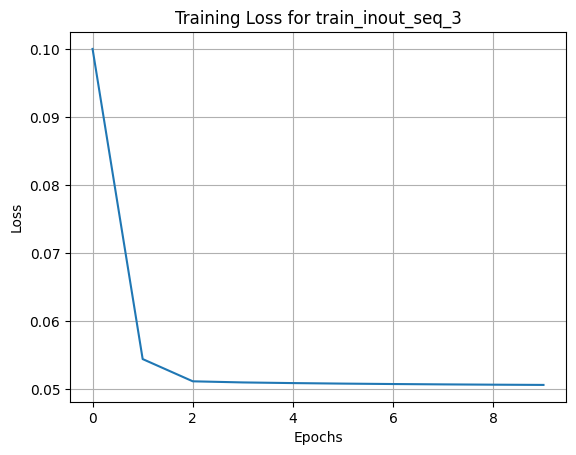

In [14]:
# Plotting the loss curve
plt.plot(range(epochs), losses_3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for train_inout_seq_3")
plt.grid(True)
plt.show()

Epoch 0 - Training Loss: 0.112209, Test Loss: 0.139717
Epoch 2 - Training Loss: 0.051416, Test Loss: 0.058049
Epoch 4 - Training Loss: 0.050989, Test Loss: 0.057107
Epoch 6 - Training Loss: 0.050795, Test Loss: 0.056651
Epoch 8 - Training Loss: 0.050669, Test Loss: 0.056320


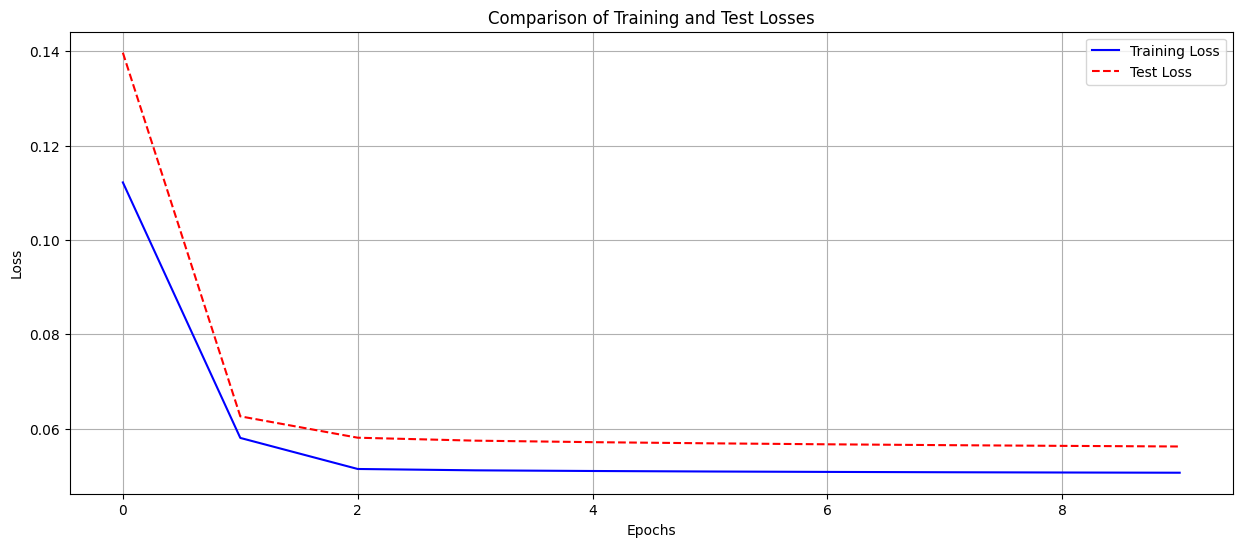

In [15]:


def train_one_epoch(model, train_data, optimizer, loss_function, train_window):
    running_loss = 0
    model.train()
    
    for seq, labels in train_data:
        optimizer.zero_grad()
        y_pred = model(torch.Tensor(seq.reshape(1, train_window, 1)))
        loss = loss_function(y_pred, torch.Tensor(labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    return running_loss / len(train_data)

def test_one_epoch(model, test_data, loss_function, train_window):
    test_loss = 0
    model.eval()
    
    with torch.no_grad():
        for seq, labels in test_data:
            y_pred = model(torch.Tensor(seq.reshape(1, train_window, 1)))
            loss = loss_function(y_pred, torch.Tensor(labels))
            test_loss += loss.item()
            
    return test_loss / len(test_data)

def main():
    # Initialize the model and training parameters
    model = RNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    loss_function = torch.nn.MSELoss()  # Assuming MSE loss. Adjust if different.

    # Lists to store losses for each epoch
    train_losses_3 = []
    test_losses_3 = []

    for epoch in range(epochs):
        avg_train_loss = train_one_epoch(model, train_inout_seq_3, optimizer, loss_function, train_window_3)
        avg_test_loss = test_one_epoch(model, test_inout_seq_3, loss_function, train_window_3)
        
        train_losses_3.append(avg_train_loss)
        test_losses_3.append(avg_test_loss)
        
        if epoch % 2 == 0:  # Print every 2nd epoch for visibility
            print(f"Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

    # Plotting the training and test losses
    plt.figure(figsize=(15, 6))
    plt.plot(train_losses_3, label="Training Loss", color="blue")
    plt.plot(test_losses_3, label="Test Loss", color="red", linestyle="dashed")
    plt.title("Comparison of Training and Test Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


Epoch 0 - Training Loss: 0.123752, Test Loss: 0.145985
Epoch 2 - Training Loss: 0.056000, Test Loss: 0.057873
Epoch 4 - Training Loss: 0.055485, Test Loss: 0.056928
Epoch 6 - Training Loss: 0.055224, Test Loss: 0.056471
Epoch 8 - Training Loss: 0.055035, Test Loss: 0.056121


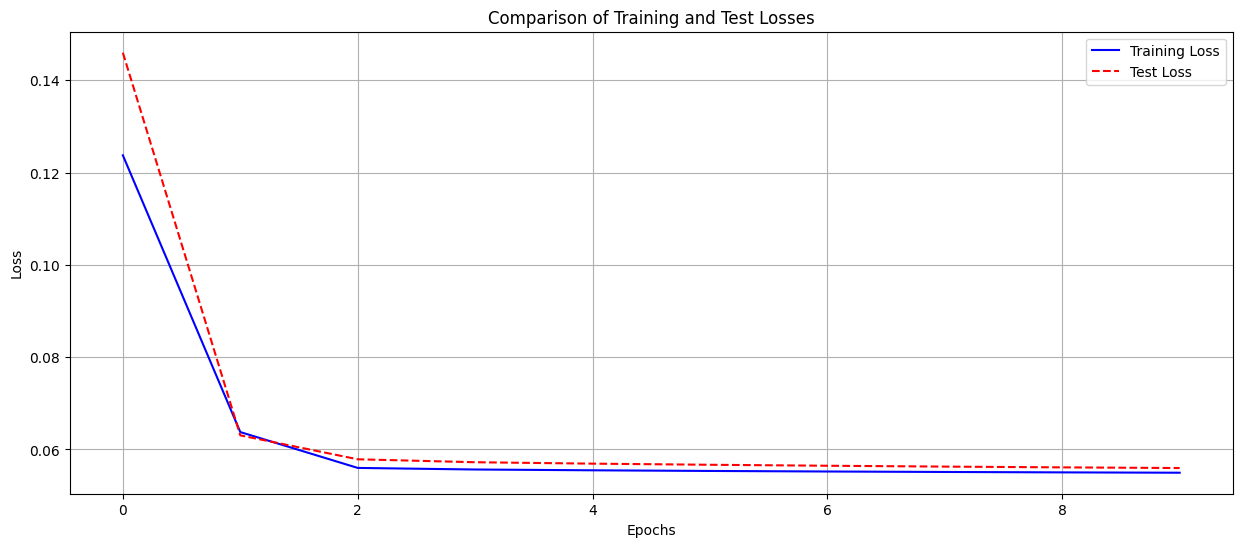

In [132]:
# Initialize the model and training parameters
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Lists to store losses for each epoch
train_losses_3 = []
test_losses_3 = []

for i in range(epochs):
    # Training
    running_loss = 0
    model.train()
    for seq, labels in train_inout_seq_3:
        optimizer.zero_grad()
        y_pred = model(torch.Tensor(seq.reshape(1, train_window_3, 1)))
        single_loss = loss_function(y_pred, torch.Tensor(labels))
        single_loss.backward()
        optimizer.step()
        running_loss += single_loss.item()
    avg_train_loss = running_loss / len(train_inout_seq_3)
    train_losses_3.append(avg_train_loss)

    # Testing
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for seq, labels in test_inout_seq_3:
            y_pred = model(torch.Tensor(seq.reshape(1, train_window_3, 1)))
            loss = loss_function(y_pred, torch.Tensor(labels))
            test_loss += loss.item()
        avg_test_loss = test_loss / len(test_inout_seq_3)
        test_losses_3.append(avg_test_loss)

    if i % 2 == 0:  # Print every 2nd epoch for visibility
        print(
            f"Epoch {i} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}"
        )

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_3, label="Training Loss", color="blue")
plt.plot(test_losses_3, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Epoch 0 - Training Loss: 0.054728, Test Loss: 0.056337
Epoch 2 - Training Loss: 0.054643, Test Loss: 0.056118
Epoch 4 - Training Loss: 0.054584, Test Loss: 0.055952
Epoch 6 - Training Loss: 0.054541, Test Loss: 0.055825
Epoch 8 - Training Loss: 0.054511, Test Loss: 0.055727


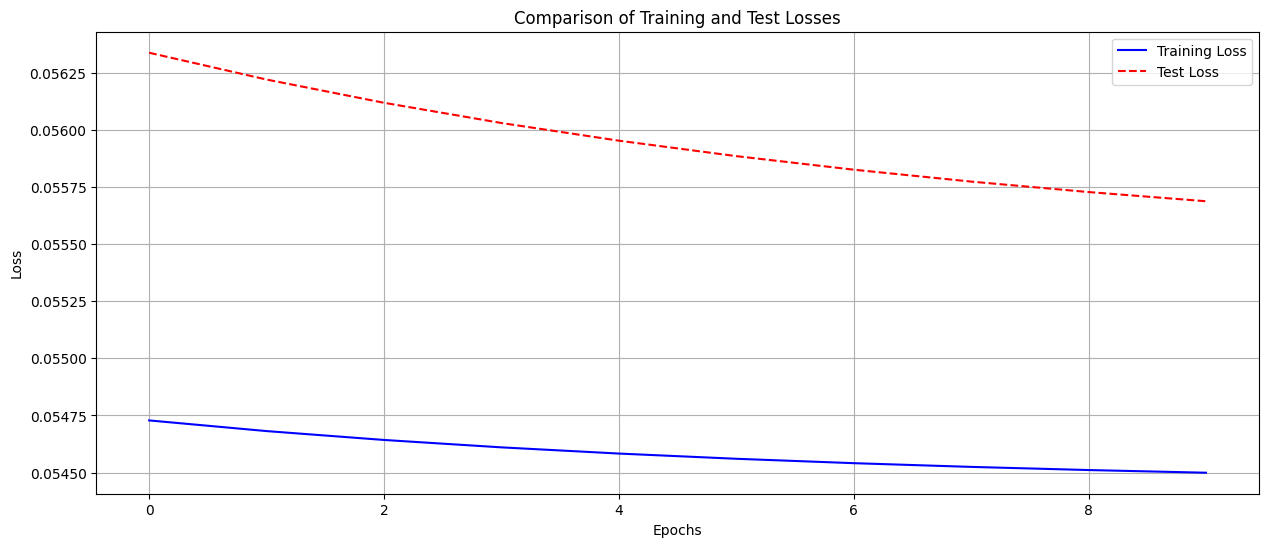

In [137]:
def train_one_epoch(model, data, optimizer, loss_function):
    running_loss = 0
    model.train()

    for seq, labels in data:
        optimizer.zero_grad()
        y_pred = model(torch.Tensor(seq.reshape(1, train_window_3, 1)))
        loss = loss_function(y_pred, torch.Tensor(labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(data)
    return avg_loss


def test_one_epoch(model, data, loss_function):
    test_loss = 0
    model.eval()

    with torch.no_grad():
        for seq, labels in data:
            y_pred = model(torch.Tensor(seq.reshape(1, train_window_3, 1)))
            loss = loss_function(y_pred, torch.Tensor(labels))
            test_loss += loss.item()

    avg_test_loss = test_loss / len(data)
    return avg_test_loss


def train_and_evaluate(epochs, model, optimizer, train_data, test_data, loss_function):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_data, optimizer, loss_function)
        train_losses.append(train_loss)

        test_loss = test_one_epoch(model, test_data, loss_function)
        test_losses.append(test_loss)

        if epoch % 2 == 0:  # Print every 2nd epoch for visibility
            print(
                f"Epoch {epoch} - Training Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}"
            )

    return train_losses, test_losses


# Run the training and testing
train_losses_3, test_losses_3 = train_and_evaluate(
    epochs, model, optimizer, train_inout_seq_3, test_inout_seq_3, loss_function
)

# Plotting the training and test losses
plt.figure(figsize=(15, 6))
plt.plot(train_losses_3, label="Training Loss", color="blue")
plt.plot(test_losses_3, label="Test Loss", color="red", linestyle="dashed")
plt.title("Comparison of Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

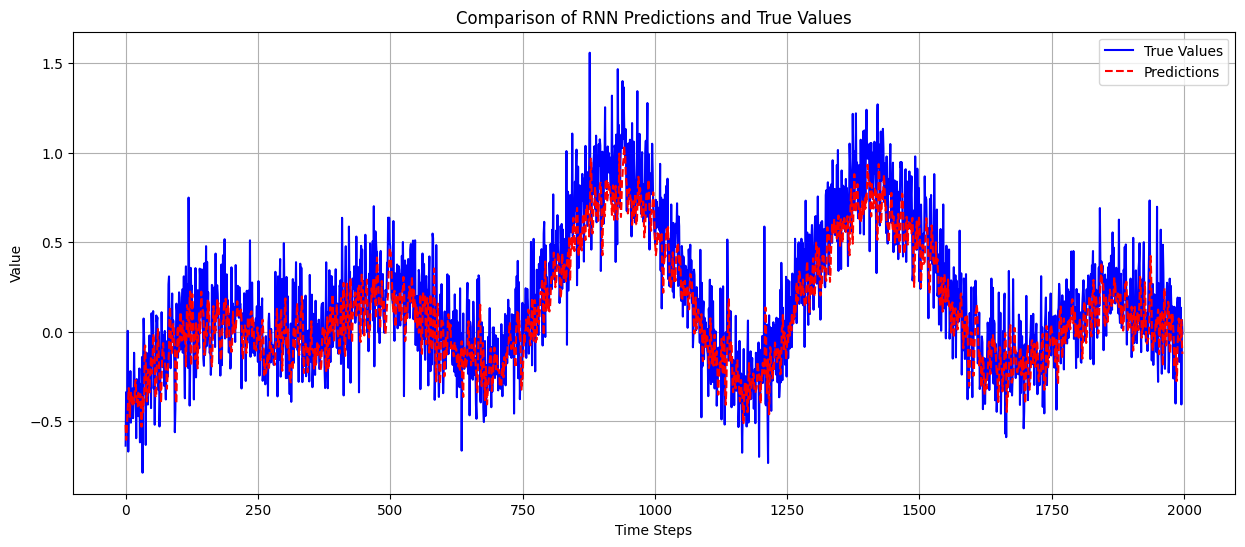

In [127]:
model.eval()
predictions = []

with torch.no_grad():
    for seq, true_val in test_inout_seq_3:
        seq_tensor = torch.Tensor(seq.reshape(1, train_window_3, 1))
        predicted_val = model(seq_tensor)
        predictions.append(predicted_val.item())

actual_values = [label[0] for _, label in test_inout_seq_3]

plt.figure(figsize=(15, 6))
plt.plot(actual_values, label="True Values", color="blue")
plt.plot(predictions, label="Predictions", color="red", linestyle="dashed")
plt.title("Comparison of RNN Predictions and True Values")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Now train an LSTM on those four different datasets, remember we use the first 3000 datapoints as training data
after training, plot the test accuracy and training accuracy for all datapoints


take that last trained RNN (for 300 datapoints) and the last LSTM, determine the next 5000 datapoints by feeding the output of the RNN (or LSTM) back into the model, plot the predictions


Which of the two models RNN or LSTM has a better prediction horizon? Write your answer as a couple of sentences, and give the reasons for your interpretation
